<a href="https://colab.research.google.com/github/CrazyHrodgar/CICATA/blob/master/pca_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicio del programa

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, brier_score_loss

from google.colab import files

import math

# Configurar el estilo de las gráficas
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('ggplot')

In [ ]:
upload = files.upload()

Saving dataset.csv to dataset.csv


# Cargando y explorando la base de datos

In [ ]:
dataframe = pd.read_csv('dataset.csv')
dataframe.head()

,gender,age,xrjsl,xrjsm,xrsctm,xrsctl,xrcyfl,xrcyfm,xrscfl,xrscfm,xrchl,xrchm,painonlyprg,jspainprg,jsonlyprg,case,womadl,womkp,bmi,xrkl
0,M,57,0,1,0,0,0,0,0,0,0,0,0,1,0,1,10.625,3,27.0,1
1,M,57,0,0,0,0,0,0,0,0,1,1,0,1,0,1,10.625,3,27.0,0
2,F,64,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.000,1,28.0,0
3,F,64,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0.000,1,28.0,2
4,M,74,0,0,0,0,0,0,0,0,0,0,0,0,0,4,10.000,8,28.8,1


In [ ]:
### Resumen estadístico de la base de datos
dataframe.describe()

,age,xrjsl,xrjsm,xrsctm,xrsctl,xrcyfl,xrcyfm,xrscfl,xrscfm,xrchl,xrchm,painonlyprg,jspainprg,jsonlyprg,case,womadl,womkp,bmi,xrkl
count,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3459.0,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3459.00000,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000
mean,62.320324,0.058977,0.991038,0.672449,0.026019,0.0,0.015033,0.030356,0.632264,0.040763,0.035849,0.166522,0.326106,0.18329,2.488581,8.725660,2.546979,30.793119,2.031801
std,8.818868,0.323536,0.858517,0.829245,0.212165,0.0,0.121703,0.217651,0.813108,0.197770,0.185939,0.372603,0.468854,0.38696,1.245269,10.921078,3.297085,4.775966,0.946288
min,45.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,18.600000,0.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,27.500000,2.000000
50%,62.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,4.000000,1.000000,30.300000,2.000000
75%,70.000000,0.000000,2.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,4.000000,14.000000,4.000000,33.800000,3.000000
max,80.000000,3.000000,3.000000,3.000000,3.000000,0.0,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.00000,4.000000,57.000000,16.000000,46.700000,4.000000


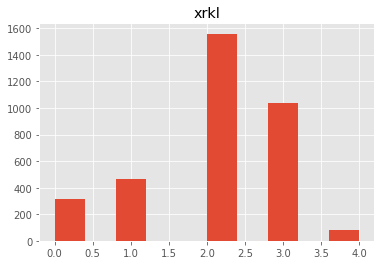

In [ ]:
### Visualizando los datos...
dataframe.hist('xrkl')
plt.show()

Los datos se ven desbalanceados por lo tanto se van a estadarizar

Cambiamos la variable gender de texto a número

M (male) --> 0

F (female) --> 1

In [ ]:
clean_data = {"gender": {"M":0,"F":1}}
data = dataframe.replace(clean_data)
data.head()

,gender,age,xrjsl,xrjsm,xrsctm,xrsctl,xrcyfl,xrcyfm,xrscfl,xrscfm,xrchl,xrchm,painonlyprg,jspainprg,jsonlyprg,case,womadl,womkp,bmi,xrkl
0,0,57,0,1,0,0,0,0,0,0,0,0,0,1,0,1,10.625,3,27.0,1
1,0,57,0,0,0,0,0,0,0,0,1,1,0,1,0,1,10.625,3,27.0,0
2,1,64,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.000,1,28.0,0
3,1,64,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0.000,1,28.0,2
4,0,74,0,0,0,0,0,0,0,0,0,0,0,0,0,4,10.000,8,28.8,1


# PCA

In [ ]:
scaler = StandardScaler()
df = data.drop(['xrkl'], axis=1) # Quitamos la variable de salida xrkl
scaler.fit(df) # Se calcula la media para hacer las transformaciones
x_scaled = scaler.transform(df) # Ahora se escalan los datos y se normalizan

In [ ]:
# pca = PCA(n_components=19) #n_components es el número total de filas de la dataset
# En lugar de definir cuantos componentes queremos analizar, indicamos el nivel de explicabilidad que queremos lograr
pca = PCA(0.90) 
pca.fit(x_scaled) # Obtenemos los componentes principales

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_pca = pca.transform(x_scaled)

print("Shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma: ', sum(expl[0:10]))

Shape of X_pca (3459, 10)
[0.17637725 0.14912749 0.11734134 0.10046991 0.08529509 0.06828272
 0.05909707 0.05359279 0.05243268 0.0424092 ]
suma:  0.9044255389347456


Con 10 componentes se puede explicar el 90% de la varianza

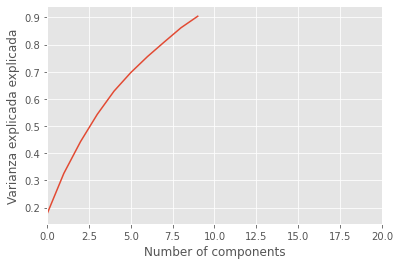

In [ ]:
### Se grafica...
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.xlim([0,20])
plt.ylabel('Varianza explicada explicada')
plt.show()

# Knn
Crearemos dos clasificadores KNN, el primero con 5 (75% de explicabilidad) características principales y el otro con 10 (90% de explicabilidad). Después se comparan los resultados.

In [ ]:
# Crear el dataframe para el 75% de explicabilidad
# la última columna será la variable de salida para el clasificador
df75 = data[['womadl','age','womkp','bmi','case','xrjsm','xrscfm','xrkl']]
df75.head()

,womadl,age,womkp,bmi,case,xrjsm,xrscfm,xrkl
0,10.625,57,3,27.0,1,1,0,1
1,10.625,57,3,27.0,1,0,0,0
2,0.000,64,1,28.0,1,0,0,0
3,0.000,64,1,28.0,1,1,1,2
4,10.000,74,8,28.8,4,0,0,1


In [ ]:
# Crear el dataframe para el 90% de explicabilidad
#la última columna será la variable de salida para el clasificador
df90 = data[['womadl','age','womkp','bmi','case',
             'xrjsm','xrscfm','gender','xrsctm','painonlyprg','xrkl']]

df90.head()

,womadl,age,womkp,bmi,case,xrjsm,xrscfm,gender,xrsctm,painonlyprg,xrkl
0,10.625,57,3,27.0,1,1,0,0,0,0,1
1,10.625,57,3,27.0,1,0,0,0,0,0,0
2,0.000,64,1,28.0,1,0,0,1,0,0,0
3,0.000,64,1,28.0,1,1,1,1,1,0,2
4,10.000,74,8,28.8,4,0,0,0,0,0,1


In [ ]:
X75 = data[['womadl','age','womkp','bmi','case','xrjsm','xrscfm']] # Variables de entrada
y75 = df75[['xrkl']] # Variable de salida

X_train75, X_test75, y_train75, y_test75 = train_test_split(X75, y75, random_state=0)
scaler = MinMaxScaler()
X_train75 = scaler.fit_transform(X_train75)
X_test75 = scaler.transform(X_test75)

Antes de comenzar el proceso de entrenamiento conviene averiguar con cuántos neighbors (vecinos) será óptimo el resulado. En este caso, con dos vecinos se logra un 79% de exactitud.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


([<matplotlib.axis.XTick at 0x7fa286922650>,
 <a list of 6 Text major ticklabel objects>)

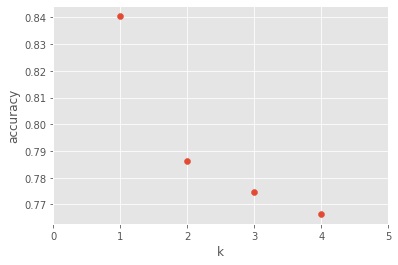

In [ ]:
k_range = range(1, 5)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train75, y_train75)
    scores.append(knn.score(X_test75, y_test75))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5])

In [ ]:
n_neighbors = 3

knn75 = KNeighborsClassifier(n_neighbors)
knn75.fit(X_train75, y_train75)
print('Accuracy del KNN en entrenamiento: {:.2f}'.format(knn75.score(X_train75, y_train75)))
print('Accuracy del KNN en test: {:.2f}'.format(knn75.score(X_test75, y_test75)))

Accuracy del KNN en entrenamiento: 0.89
Accuracy del KNN en test: 0.77


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
### Precisión para el 75% de explicabilidad
pred = knn75.predict(X_test75)
print(confusion_matrix(y_test75, pred))
print(classification_report(y_test75, pred))

[[ 50   4  27   0   0]
 [ 10  39  52   4   0]
 [ 38  36 311   3   0]
 [  2   0   4 251   6]
 [  1   1   1   6  19]]
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        81
           1       0.49      0.37      0.42       105
           2       0.79      0.80      0.79       388
           3       0.95      0.95      0.95       263
           4       0.76      0.68      0.72        28

    accuracy                           0.77       865
   macro avg       0.70      0.68      0.69       865
weighted avg       0.77      0.77      0.77       865



In [ ]:
### KNN para el 90% de explicabilidad
X90 = df90[['womadl','age','womkp','bmi','case',
             'xrjsm','xrscfm','gender','xrsctm','painonlyprg']] # Variables de entrada
y90 = df90[['xrkl']] # Variable de salida

X_train90, X_test90, y_train90, y_test90 = train_test_split(X90, y90, random_state=0)
scaler = MinMaxScaler()
X_train90 = scaler.fit_transform(X_train90)
X_test90 = scaler.transform(X_test90)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

([<matplotlib.axis.XTick at 0x7fa28685bd10>,
 <a list of 6 Text major ticklabel objects>)

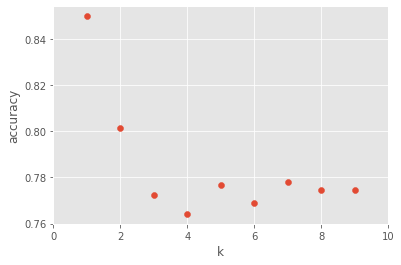

In [ ]:
k_range = range(1, 10)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train90, y_train90)
    scores.append(knn.score(X_test90, y_test90))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,2,4,6,8,10])

In [ ]:
n_neighbors = 2

knn90 = KNeighborsClassifier(n_neighbors)
knn90.fit(X_train90, y_train90)
print('Accuracy del KNN en entrenamiento: {:.2f}'.format(knn90.score(X_train90, y_train90)))
print('Accuracy del KNN en test: {:.2f}'.format(knn90.score(X_test90, y_test90)))

Accuracy del KNN en entrenamiento: 0.91
Accuracy del KNN en test: 0.80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
### Precisión para el 90% de explicabilidad
pred90 = knn90.predict(X_test90)
print(confusion_matrix(y_test90, pred90))
print(classification_report(y_test90, pred90))

[[ 66   6   9   0   0]
 [  6  70  29   0   0]
 [ 43  51 293   1   0]
 [  0   2   8 251   2]
 [  0   1   1  13  13]]
              precision    recall  f1-score   support

           0       0.57      0.81      0.67        81
           1       0.54      0.67      0.60       105
           2       0.86      0.76      0.80       388
           3       0.95      0.95      0.95       263
           4       0.87      0.46      0.60        28

    accuracy                           0.80       865
   macro avg       0.76      0.73      0.73       865
weighted avg       0.82      0.80      0.81       865



In [ ]:
print(classification_report(y_test75, pred))

              precision    recall  f1-score   support

           0       0.50      0.62      0.55        81
           1       0.49      0.37      0.42       105
           2       0.79      0.80      0.79       388
           3       0.95      0.95      0.95       263
           4       0.76      0.68      0.72        28

    accuracy                           0.77       865
   macro avg       0.70      0.68      0.69       865
weighted avg       0.77      0.77      0.77       865



In [ ]:
# ### ROC y Brier score para el 75% de variabilidad
# roc75 = roc_auc_score(y_test75, pred)
# print(roc75)
# brier75 = brier_score_loss(y_test75, pred)
# print(brier75)

In [ ]:
# ### ROC y Brier score para el 90% de variabilidad
# roc90 = roc_auc_score(y_test90, pred90)
# print(roc90)
# brier75 = brier_score_loss(y_test90, pred90)
# print(brier90)

# KNN regresor
Usar un modelo KNN para predicir los valores

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
XR75 = X_train75
YR75 = y_train75
kr75 = KNeighborsRegressor(n_neighbors=3)
kr75.fit(XR75, YR75)

print('Accuracy del KNN en entrenamiento: {:.2f}'.format(kr75.score(XR75,YR75)))

Accuracy del KNN en entrenamiento: 0.83


In [ ]:
XR90 = X_train90
YR90 = y_train90
kr90 = KNeighborsRegressor(n_neighbors=2)
kr90.fit(XR90, YR90)

print('Accuracy del KNN en entrenamiento: {:.2f}'.format(knn90.score(XR90, YR90)))

Accuracy del KNN en entrenamiento: 0.91
